In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm


# Settings

In [4]:
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_MH_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_MH_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_MH_up.pckl"),
}


In [5]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.47937914 13.47937914 16.64221592 ... 23.82743744  0.
   0.        ]
 [17.02848656 17.02848656 20.63478084 ... 20.27620928  0.
   0.        ]
 [19.13943583 19.13943583 22.97704711 ... 18.70430083  0.
   0.        ]]


# Atmospheric background

In [7]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true


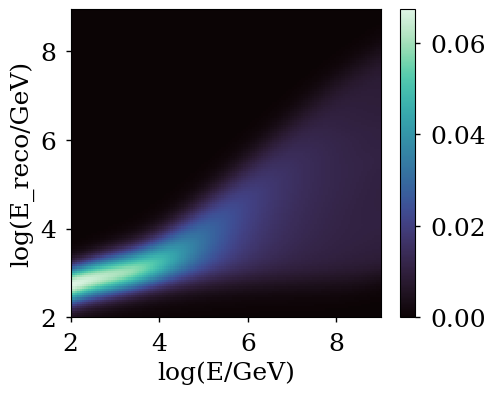

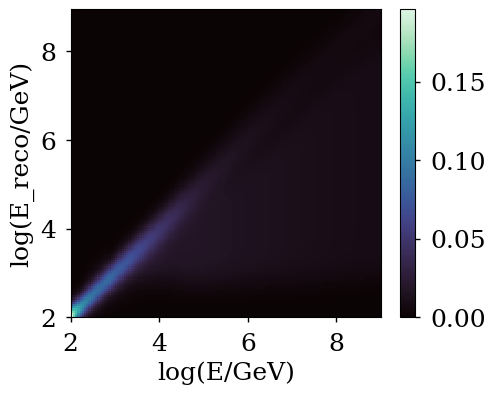

In [9]:
baseline_eres.plot()
plt.colorbar()

improved_eres.plot()
plt.colorbar()


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [10]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

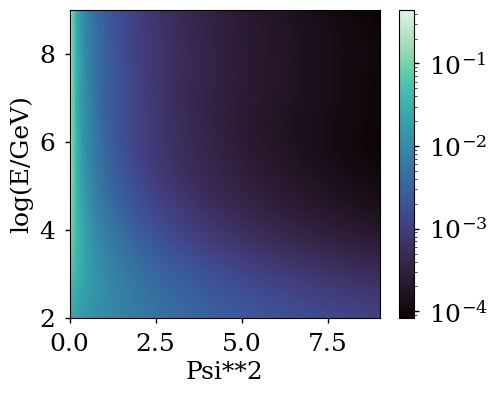

In [11]:
e_psi2_grid.plot(norm=LogNorm())
plt.colorbar()

# Flux definition

In [12]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
}

## NGC1068 source parameters

In [13]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(LOCALPATH, "tenyr_paper_68_contour.txt"))

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [14]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [15]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 85.16199270234627


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know


For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$
* mu -> 0, k>0     --> P -> 0
* k -> 0, mu>0     --> P -> exp(-mu)
* k -> 0, mu -> 0  --> P -> 1

In [16]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


# NGC 1068
## Significance test Background vs. Background + Signal

## 2D contour

In [17]:
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {
        "colors": [poles["Plenum-1"]["color"]],
        "linestyles": poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [poles["Plenum-2"]["color"]],
        "linestyles": poles["Plenum-2"]["ls"],
    },
}

In [57]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
step = 0.05
gamma_astro = np.arange(2.5, 4, step=step)
astro_scaling = np.arange(0.2, 1.8, step=step)

tmp_SPL = []

for ident in idents:

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    
    if "Plenum" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
        shape="powerlaw"
    )

    global_llh = lambda x: ps_llh_2d_composite(x, **dct)
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )

    if out[2]["warnflag"] != 0:
        print("WARNING!!")
        print("bf param:", out[0])
    
    tmp = dict()
    tmp["LLH"] = "global"
    tmp["energy_res"] = "baseline"
    tmp["ident"] = ident

    tmp["ts"] = out[1]
    tmp["conv"] = out[0][0]
    tmp["phi_astro"] = out[0][1]
    tmp["gamma"] = out[0][2]
    tmp_SPL.append(tmp)

    print("starting local fits...")
    for aa, gg in product(astro_scaling, gamma_astro):
        # local min with fixed phi_astro
        local_llh = lambda x: ps_llh_2d_composite((x[0], aa, gg), **dct)
        local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
        if local_out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", local_out[0])

        tmp = dict()
        tmp["LLH"] = "local"
        tmp["energy_res"] = "baseline"
        tmp["ident"] = ident

        tmp["ts"] = local_out[1]
        tmp["delta_ts"] = local_out[1] - out[1]
        tmp["conv"] = local_out[0][0]
        tmp["phi_astro"] = aa
        tmp["gamma"] = gg
        tmp_SPL.append(tmp)
print("done")
SPL_df = pd.DataFrame(tmp_SPL)
#SPL_df.to_pickle( join(LOCALPATH, "ngc_contour_spl.pickle"))

starting local fits...
starting local fits...
starting local fits...
done


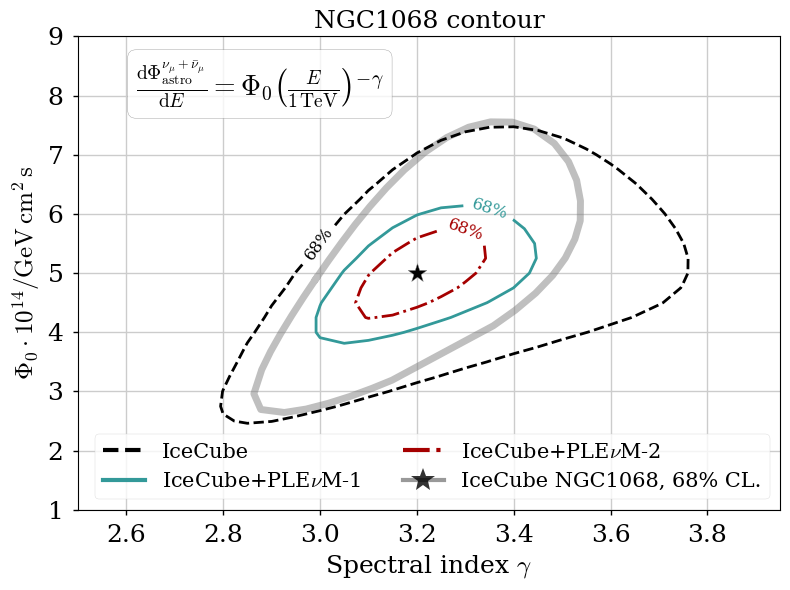

In [58]:
eres_key = "baseline"
f, ax = plt.subplots(figsize=(8, 6))
ref_color = "gray"
ax.plot(
    gamma_c_68,
    phi_c_68 * 1e11,
    color=ref_color,
    ls="-",
    lw=5,
    alpha=0.5,
)

# draw contour levels
cvals = [0.32]
lbs = ["68%"]
levels = chi2.isf(cvals, 2)

res_local = SPL_df.loc[(SPL_df.LLH == "local")] # & (SPL_df.energy_res == eres_key)]
res_global = SPL_df.loc[(SPL_df.LLH == "global")] # & (SPL_df.energy_res == eres_key)]

for ident, series in res_local.groupby(["ident"]):
    local_pivot = series.pivot(index="gamma", columns="phi_astro", values="delta_ts")
    sc = ax.contour(
        gamma_astro,# local_pivot.index,
        astro_scaling * ngc_flux.norm * 1e14, #local_pivot.columns
        local_pivot.T,
        levels=levels,
        lw=3,
        **contour_formats[ident],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
# best fit
ax.scatter(
    res_global.gamma.unique(),
    res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
    marker="*",
    s=200,
    color="k",
    edgecolor=ref_color,
)
lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IceCube",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-2",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label=r"IceCube NGC1068, 68% CL.",
    ),
]
ax.set_ylim(1, 9)
# ax.set_xlim(2.0, 2.7)
ax.legend(handles=lines, loc=4, ncol=2, fontsize=15)
ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
ax.set_xlabel(r"Spectral index $\gamma$")
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
ax.text(
    2.62,
    8.0,
    flux_str,
    fontsize=20,
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
)
ax.set_title("NGC1068 contour")
f.tight_layout()
# f.savefig(f"../../plots/2D_scan_ngc1068.pdf")
#f.savefig(f"../../plots/2D_scan_ngc1068_{eres_key}.png")


In [93]:
# contour coordinates:
# sc.allsegs